In [1]:
import cv2
import glob
import os
import time
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import pyplot

from moviepy.editor import VideoFileClip

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

import features_classifier

%matplotlib inline

In [2]:
cars = []
notcars = []

In [3]:
def get_images_from_folder(path):
    result = []
    image_names = os.listdir(path)
    
    for image_name in image_names:
        result.extend(glob.glob(path + "/" + image_name + "/*"))
    
    print (len(result))
    return result

In [4]:
def show_plot(images, titles, rows, cols):
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        image_dimensions = len(image.shape)
        title = titles[i]
        if image_dimensions < 3:
            plt.imshow(image, cmap='hot')
            plt.title(title)
        else:
            plt.imshow(image)
            plt.title(title)

In [5]:
def draw_boxes(img, boxes, thick=6, color=(0, 0, 255)):
    imcopy = np.copy(img)
    for box in boxes:
        cv2.rectangle(imcopy, box[0], box[1], color, thick)
    return imcopy

In [6]:
def show_image_and_hog(image, postfix):
    color_space = 'RGB'
    orient = 6
    pixels_per_cell = 8
    cells_per_block = 2
    hog_channel = 0
    spatial_size = (16, 16)
    histogram_bins = 16
    spatial_features = True
    hisogram_features = True
    hog_features = True
    
    features, hog_image = features_classifier.extract_features(image, color_space=color_space, spatial_size=spatial_size, 
                                                              hist_bins=histogram_bins, orient=orient, 
                                                              pix_per_cell=pixels_per_cell, cell_per_block=cells_per_block,
                                                              hog_channel=hog_channel, spatial_feat=spatial_features,
                                                              hist_feat=hisogram_features, hog_feat=hog_features, vis=True)
    images = [image, hog_image]
    titles = ["original image", "HOG image"]
    
    write_name = './output_images/processed_' + postfix + '.png'
    pyplot.imsave(write_name, image)
    
    write_name = './output_images/processed_' + postfix + '_hog.png'
    pyplot.imsave(write_name, hog_image)
    #cv2.imwrite(write_name, hog_image*255)
    
    show_plot(images, titles, 1, 2)

In [7]:
cars = get_images_from_folder('data/vehicles')

8792


In [8]:
notcars = get_images_from_folder('data/non-vehicles')

8968


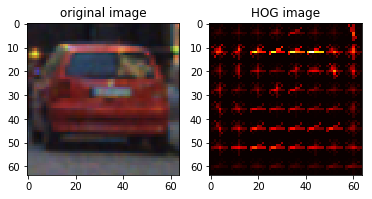

In [9]:
car_index = np.random.randint(0, len(cars))
car_image = mpimg.imread(cars[car_index])
show_image_and_hog(car_image, "car")

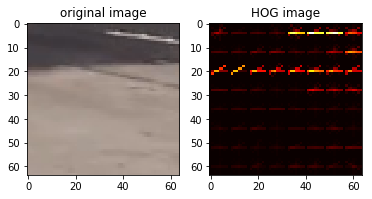

In [13]:
notcar_index = np.random.randint(0, len(notcars))
notcar_image = mpimg.imread(notcars[notcar_index])
show_image_and_hog(notcar_image, "not_car")

# Global settings for training and processing

In [14]:
color_space = 'YCrCb' #RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pixels_per_cell = 8
cells_per_block = 2
hog_channel = "ALL" #0, 1, 2, "ALL"
spatial_size = (32, 32)
histogram_bins = 32
y_range = [400, 656]
spatial_features = True
hisogram_features = True
hog_features = True
svc = LinearSVC()
x_scaler = None
heatmap_threshold = 1.5
video_resolution = (720, 1280)
heatmaps_to_change_average = 15

## Train model

In [15]:
def train_model():    
    start_time = time.time()
    samples = 1000
    random_indexes = np.random.randint(0, len(cars), samples)
    test_cars = cars# np.array(cars)[random_indexes]
    test_notcars = notcars #np.array(notcars)[random_indexes]
    
    test_car_features = []
    for test_car_fname in test_cars:
        image = mpimg.imread(test_car_fname)
        
        car_features = features_classifier.extract_features(image, color_space=color_space, spatial_size=spatial_size, 
                                                            hist_bins=histogram_bins, orient=orient, 
                                                            pix_per_cell=pixels_per_cell, cell_per_block=cells_per_block,
                                                            hog_channel=hog_channel, spatial_feat=spatial_features,
                                                            hist_feat=hisogram_features, hog_feat=hog_features, vis=False)
        test_car_features.append(car_features)

        
    test_notcar_features = []
    for test_notcar_fname in test_notcars:
        image = mpimg.imread(test_notcar_fname)
        
        notcar_features = features_classifier.extract_features(image, color_space=color_space, spatial_size=spatial_size, 
                                                               hist_bins=histogram_bins, orient=orient, 
                                                               pix_per_cell=pixels_per_cell, cell_per_block=cells_per_block,
                                                               hog_channel=hog_channel, spatial_feat=spatial_features,
                                                               hist_feat=hisogram_features, hog_feat=hog_features, vis=False)
        test_notcar_features.append(notcar_features)
    
    x = np.vstack((test_car_features, test_notcar_features)).astype(np.float64)
    global x_scaler
    x_scaler = StandardScaler().fit(x)
    scaled_x = x_scaler.transform(x)
       
    y = np.hstack((np.ones(len(test_car_features)), np.zeros(len(test_notcar_features))))
    
    random_state = np.random.randint(0, 100)
    #Split training and test sets
    x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.1, random_state=random_state)
    
    svc.fit(x_train, y_train)
        
    print("TestAccuracy = {test_accuracy}".format(test_accuracy=round(svc.score(x_test, y_test), 4)))
    
    return x_scaler

In [16]:
x_scaler = train_model()

TestAccuracy = 0.9899


# Processing test images

In [17]:
def slide_multiple_windows(image):
    x_range = [None, None]
    xy_window = (96, 96)
    overlap = 0.5
    
    result_image = np.copy(image)
    windows = features_classifier.slide_window(image, x_start_stop=x_range, y_start_stop=y_range, 
                                               xy_window=xy_window, xy_overlap=(overlap, overlap))
    
    hot_windows = features_classifier.search_windows(image, windows, svc, x_scaler, color_space=color_space, 
                                                     spatial_size=spatial_size, hist_bins=histogram_bins, orient=orient, 
                                                     pix_per_cell=pixels_per_cell, cell_per_block=cells_per_block, 
                                                     hog_channel=hog_channel, spatial_feat=spatial_features, 
                                                     hist_feat=hisogram_features, hog_feat=hog_features)
    
    image_with_windows = draw_boxes(result_image, hot_windows, thick=6)
    
    return image_with_windows

In [18]:
def slide_multiple_windows_on_images(path):
    image_paths = glob.glob(path)
    images = []
    titles = []
    for image_path in image_paths:
        image = mpimg.imread(image_path)
        # jpg -> png
        image = image.astype(np.float32)/255
        image_with_windows = slide_multiple_windows(image)
        images.append(image_with_windows)
        titles.append('')
        
        write_name = './output_images/processed_slide_multiple_windows.png'
        pyplot.imsave(write_name, image_with_windows)      
    
    fig = plt.figure(figsize=(12, 18))
    show_plot(images, titles, 5, 2)

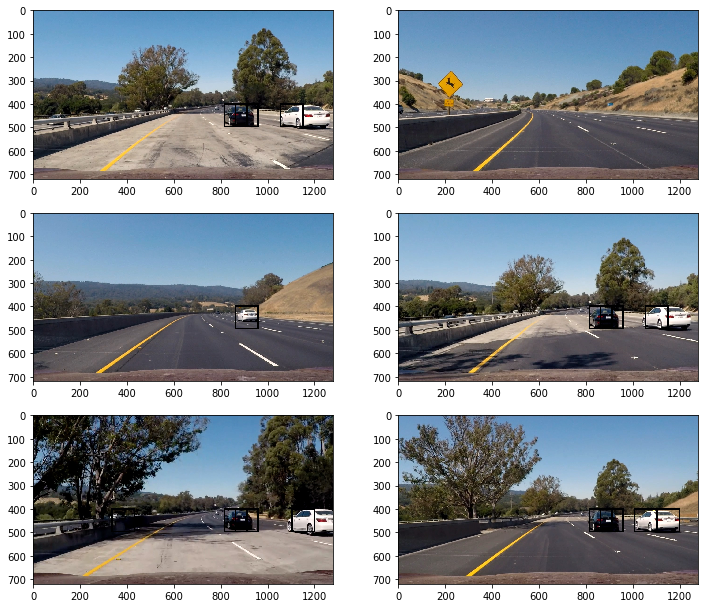

In [19]:
slide_multiple_windows_on_images("test_images/*")

In [20]:
def convert_RGB_color(image, convert):
    if convert == "RGB2YCrCb":
        return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    if convert == "RGB2LUV":
        return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    
    raise NotImplemented

In [21]:
def convert_image(image):
    return image.astype(np.float32)/255

In [22]:
def find_cars_on_image(image, scale):
    window = 64
    cells_per_step = 2
    
    result = np.copy(image)
    heatmap = np.zeros_like(image[:,:,0])
    box = None
    
    image = convert_image(image)
    
    cropped_image = image[y_range[0]:y_range[1],:,:]
    color_transformed_image = convert_RGB_color(cropped_image, "RGB2YCrCb")
    
    if scale != 1:
        image_shape = color_transformed_image.shape
        color_transformed_image = cv2.resize(color_transformed_image, 
                                             (np.int(image_shape[1]/scale), np.int(image_shape[0]/scale)))
        
    channel_1 = color_transformed_image[:,:,0]
    channel_2 = color_transformed_image[:,:,1]
    channel_3 = color_transformed_image[:,:,2]
    
    hog_x_blocks = (channel_1.shape[1] // pixels_per_cell) - 1
    hog_y_blocks = (channel_1.shape[0] // pixels_per_cell) - 1
    
    features_per_block = orient * cells_per_block**2
    blocks_per_window = (window // pixels_per_cell) - 1
    
    x_steps = (hog_x_blocks - blocks_per_window) // cells_per_step
    y_steps = (hog_y_blocks - blocks_per_window) // cells_per_step
    
    hog_channel_1 = features_classifier.get_hog_features(channel_1, orient, pix_per_cell=pixels_per_cell, 
                                                         cell_per_block=cells_per_block, feature_vec=False)
    hog_channel_2 = features_classifier.get_hog_features(channel_2, orient, pix_per_cell=pixels_per_cell, 
                                                         cell_per_block=cells_per_block, feature_vec=False)
    hog_channel_3 = features_classifier.get_hog_features(channel_3, orient, pix_per_cell=pixels_per_cell, 
                                                         cell_per_block=cells_per_block, feature_vec=False)
    
    for x_step in range(x_steps):
        for y_step in range(y_steps):
            x_position = x_step * cells_per_step
            y_position = y_step * cells_per_step
            x_left = x_position * pixels_per_cell
            y_top = y_position * pixels_per_cell
            
            hog_features_channel_1 = hog_channel_1[y_position:y_position + blocks_per_window, 
                                                   x_position:x_position + blocks_per_window].ravel()
            hog_features_channel_2 = hog_channel_2[y_position:y_position + blocks_per_window, 
                                                   x_position:x_position + blocks_per_window].ravel()
            hog_features_channel_3 = hog_channel_3[y_position:y_position + blocks_per_window, 
                                                   x_position:x_position + blocks_per_window].ravel()
            hog_features = np.hstack((hog_features_channel_1, hog_features_channel_2, hog_features_channel_3))
            
            image_region = cv2.resize(color_transformed_image[y_top:y_top + window, x_left:x_left + window], (64, 64))
            
            spatial_features = features_classifier.bin_spatial(image_region, size=spatial_size)
            histogram_features = features_classifier.color_hist(image_region, nbins=histogram_bins)
            
            features_stack = np.hstack((spatial_features, histogram_features, hog_features)).reshape(1, -1)
            
            test_features = x_scaler.transform(features_stack)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                x_box_left = np.int(x_left * scale)
                y_top_draw = np.int(y_top * scale)
                window_draw = np.int(window * scale)
                cv2.rectangle(result, (x_box_left, y_top_draw + y_range[0]),
                              (x_box_left + window_draw, y_top_draw + window_draw + y_range[0]), (255, 0, 0), 3)
                box = ((x_box_left, y_top_draw + y_range[0]), (x_box_left + window_draw, y_top_draw + window_draw + y_range[0]))
                heatmap[y_top_draw + y_range[0]:y_top_draw + window_draw + y_range[0], x_box_left:x_box_left + window_draw] += 1
    
    return result, heatmap, box

In [23]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [24]:
def draw_labeled_boxes(image, labels, color=(255, 0, 0), thick=6):
    for number_of_cars in range(1, labels[1] + 1):
        nonzero = (labels[0] == number_of_cars).nonzero()
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])
        
        box = ((np.min(nonzero_x), np.min(nonzero_y)), (np.max(nonzero_x), np.max(nonzero_y)))
        
        cv2.rectangle(image, box[0], box[1], color, thick)
    
    return image

In [27]:
def find_cars_on_images(path):
    result_images = []
    result_titles = []
    scale = 1.5
    
    image_paths = glob.glob(path)
    for image_path in image_paths:
        image = mpimg.imread(image_path)
        
        processed_image, heatmap, box = find_cars_on_image(image, scale)
        labels = label(heatmap)
        
        result_image = draw_labeled_boxes(np.copy(image), labels)

        result_images.append(result_image)
        result_images.append(heatmap)
        
        result_titles.append(image_path)
        result_titles.append("Heatmap " + image_path)

        write_name = './output_images/processed_' + image_path[-9:-4] + '.png'
        pyplot.imsave(write_name, processed_image)
        
        write_name = './output_images/processed_' + image_path[-9:-4] + '_heatmap.png'
        pyplot.imsave(write_name, heatmap)        
            
    fig = plt.figure(figsize=(12, 36))
    show_plot(result_images, result_titles, 10, 2)

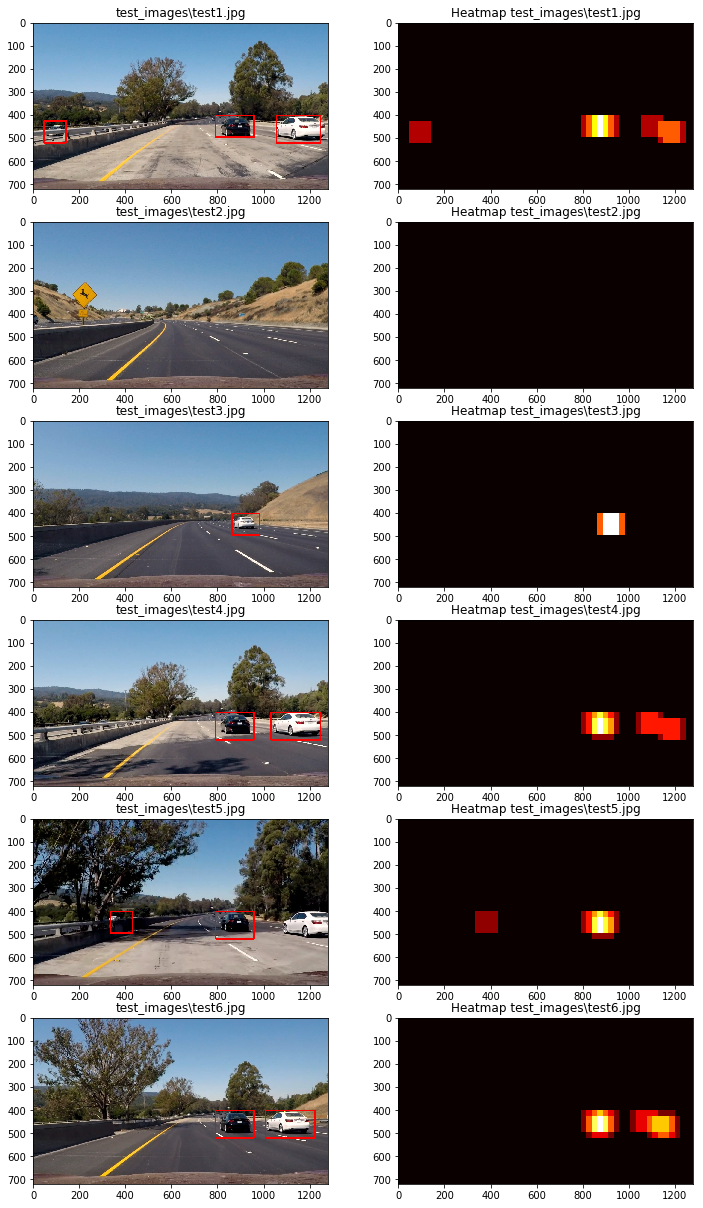

In [28]:
find_cars_on_images("test_images/*")

In [29]:
def process_video_image(image):
    scale = 1.5
    result_image, heatmap, box = find_cars_on_image(image, scale)
    
    heatmap = apply_threshold(heatmap, heatmap_threshold)
    global heatmap_sum
    heatmaps = []
    heatmaps.append(heatmap)
    heatmap_sum += heatmap
    if len(heatmaps) > heatmaps_to_change_average:
        previous_heatmap = heatmaps.pop(0)
        heatmap_sum -= previous_heatmap
        heatmap_sum = np.clip(heatmap_sum, .0, 1000000.00)
    
    heatmap_avg = np.divide(heatmap_sum, len(heatmaps))
    labels = label(heatmap_avg)
    
    image_with_boxes = draw_labeled_boxes(np.copy(image), labels)
    
    return image_with_boxes

In [30]:
def process_video(input_path, output_path):
    clip = VideoFileClip(input_path)
    output_clip = clip.fl_image(process_video_image)
    output_clip.write_videofile(output_path, audio=False)

In [26]:
heatmap_sum = np.zeros(video_resolution).astype(np.float64)
process_video("test_video.mp4", "test_video_processed.mp4")

[MoviePy] >>>> Building video test_video_processed.mp4
[MoviePy] Writing video test_video_processed.mp4


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 38/39 [00:17<00:00,  2.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_processed.mp4 



In [28]:
heatmap_sum = np.zeros(video_resolution).astype(np.float64)
process_video("project_video.mp4", "project_video_processed.mp4")

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:38<00:00,  2.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

